In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, RationalQuadratic, DotProduct
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# utility functions
def f(T, m, Tc=1.25):
    return 0.5*(1-Tc/T)*m**2 + (Tc/T)**3*m**4/12

def compute_bic(gp: GaussianProcessRegressor, X: np.ndarray, y:np.ndarray) -> float:
    """
    Compute the Bayesian Information Criterion (BIC) for a given Gaussian Process model.
    
    Parameters:
    gp (GaussianProcessRegressor): The fitted Gaussian Process model.
    X (np.ndarray): The input data used to fit the model.
    y (np.ndarray): The target values used to fit the model.
    
    Returns:
    float: The BIC value.
    """
    n = X.shape[0]
    k = gp.kernel_.theta.shape[0]
    log_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    
    bic = log_likelihood - 0.5 * k * np.log(n)
    return bic

base_kernels = {
    'LIN': ConstantKernel(1.0) * DotProduct(),
    'RBF': ConstantKernel(1.0) * RBF(length_scale=1.0),
    'Matern': ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5),
    'RationalQuadratic': ConstantKernel(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)
}

def iterative_kernel_search(X:np.ndarray, y:np.ndarray, base_kernels:dict=base_kernels, max_iter: int =10):
    """Algorithm for determining the best kernel for a Gaussian Process model using iterative kernel search."""
    bic_scores = {}
    for name, kernel in base_kernels.items():
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        gp.fit(X, y)
        bic_scores[name] = compute_bic(gp, X, y)
    best_name = max(bic_scores, key=bic_scores.get)
    best_kernel = base_kernels[best_name]
    best_bic = bic_scores[best_name]

    for _ in range(max_iter):
        candidates = {}
        for name, kernel in base_kernels.items():
            if name == best_name:
                continue
            for op, combo_k in [('+', best_kernel + kernel), ('*', best_kernel * kernel)]:
                combo_name = f"{best_name}{op}{name}"
                gp = GaussianProcessRegressor(kernel=combo_k, normalize_y=True)
                gp.fit(X, y)
                bic_val = compute_bic(gp, X, y)
                candidates[combo_name] = (bic_val, combo_k)
        combo_name, (combo_bic, combo_k) = max(candidates.items(), key=lambda item: item[1][0])
        if combo_bic > best_bic:
            best_name = combo_name
            best_kernel = combo_k
            best_bic = combo_bic
        else:
            break
    return best_kernel

def build_rectangles(T, m):
    """Build rectangles for full, training, and testing datasets."""
    T_mid = (T.min() + T.max()) / 2

    R_full = {
        'T_min': T.min(), 'T_max': T.max(),
        'm_min': m.min(), 'm_max': m.max()
    }

    R_train = {
        'T_min': T_mid, 'T_max': T.max(),
        'm_min': m.min(), 'm_max': m.max()
    }

    R_test = {
        'T_min': T.min(), 'T_max': T_mid,
        'm_min': m.min(), 'm_max': m.max()
    }
    return R_full, R_train, R_test

def mask_in_rect(T, m, R):
    """Create a boolean mask for points inside the rectangle R in the (T, m) space."""
    return (
        (T >= R['T_min']) & (T <= R['T_max']) &
        (m >= R['m_min']) & (m <= R['m_max'])
    )
def rect_area(R):
    """Compute the area of a rectangle."""
    return (R['T_max'] - R['T_min']) * (R['m_max'] - R['m_min'])


In [3]:
# parameters and dataset

Tc = 1.25
alpha = 1e-5

np.random.seed(0)
N = 10000
T = np.random.uniform(0.8, 2.2, N)
m = np.random.uniform(-1.25, 1.25, N)
y = f(T, m)

R_full, R_train, R_test = build_rectangles(T, m)

mask_train = mask_in_rect(T, m, R_train)
mask_test = mask_in_rect(T, m, R_test)

print(f"Training samples: {mask_train.sum()}, Testing samples: {mask_test.sum()}")

A_full = rect_area(R_full)
A_train = rect_area(R_train)
A_test = rect_area(R_test) 

print(f"Training Area: {A_train}, Testing Area: {A_test}, Full Area: {A_full}")
rho_P = A_full / A_train
rho_Q = A_full / A_test

Training samples: 4936, Testing samples: 5064
Training Area: 1.7494769205565703, Testing Area: 1.7494769205565703, Full Area: 3.4989538411131407


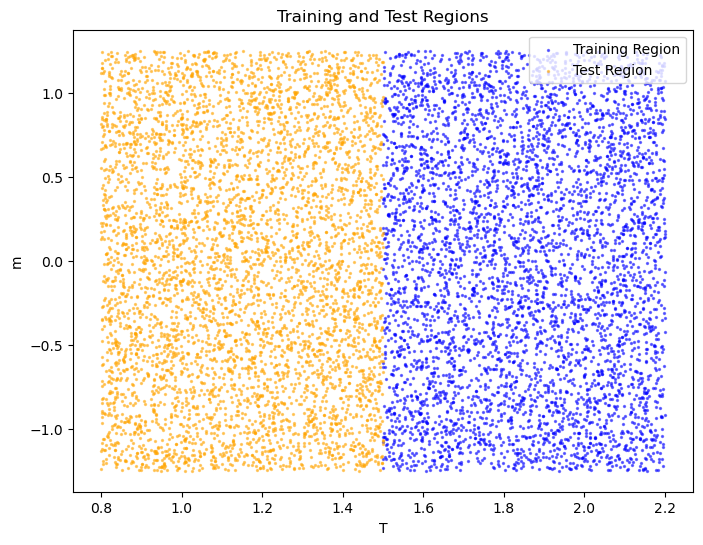

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(T[mask_train], m[mask_train], s=2, color='blue', label='Training Region', alpha=0.5)
plt.scatter(T[mask_test], m[mask_test], s=2, color='orange', label='Test Region', alpha=0.5)
plt.xlabel('T')
plt.ylabel('m')
plt.title('Training and Test Regions')
plt.legend()
plt.show()

In [6]:
# polynomial regression
train_maes = []
test_maes = []
train_mses = []
test_mses = []
bound_abs_Cdd = []
bound_mse_Cdd = []
bound_abs_remez = []
bound_mse_remez = []
n = 2

degrees = [x for x in range(2, 13)]

for d in degrees: 
    X_train_poly = np.column_stack([T[mask_train], m[mask_train]])
    X_test_poly = np.column_stack([T[mask_test], m[mask_test]])
    y_train_poly = y[mask_train]
    y_test_poly = y[mask_test]

    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=d, include_bias=True)),
        ('ridge', Ridge(alpha=alpha))
    ])

    poly_model.fit(X_train_poly, y_train_poly)
    y_train_pred = poly_model.predict(X_train_poly)
    y_test_pred = poly_model.predict(X_test_poly)

    train_mae = mean_absolute_error(y_train_poly, y_train_pred)
    test_mae = mean_absolute_error(y_test_poly, y_test_pred)
    train_mse = mean_squared_error(y_train_poly, y_train_pred)
    test_mse = mean_squared_error(y_test_poly, y_test_pred)

    train_maes.append(train_mae)
    test_maes.append(test_mae)
    train_mses.append(train_mse)
    test_mses.append(test_mse)

    bound_abs_Cdd.append((d**d)*rho_Q*(rho_P**d)*train_mae)
    bound_mse_Cdd.append(((2*d)**(2*d))*rho_Q*(rho_P**(2*d))*train_mse)

    sup_abs_remez = np.max(np.abs(y_train_poly - y_train_pred))
    sup_mse_remez = np.max((y_train_poly - y_train_pred)**2)

    bound_abs_remez.append( (4 * n * rho_Q)**d * sup_abs_remez)
    bound_mse_remez.append( (4 * n * rho_Q)**(2*d) * sup_mse_remez)
print("Done")

Done


Text(0.5, 1.0, 'MSE vs Degree')

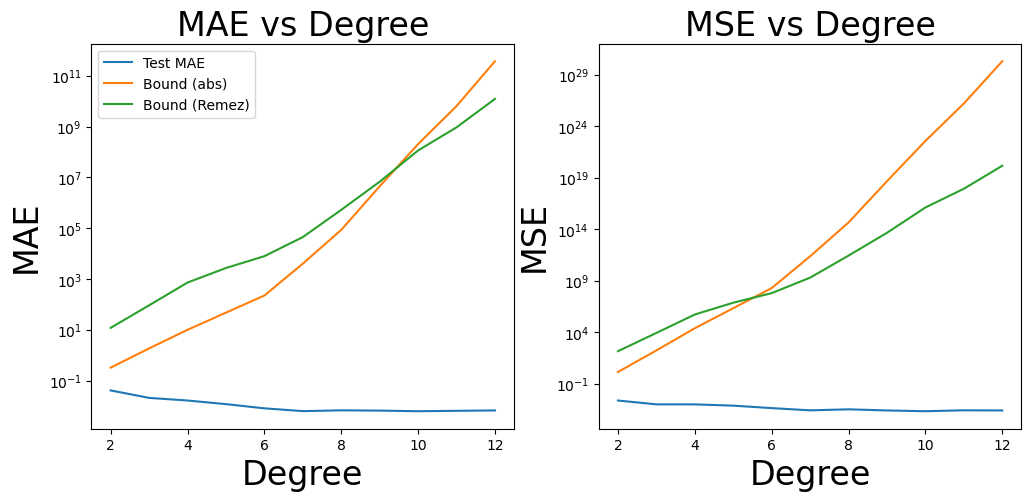

In [8]:
# plot bounds

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(degrees, test_maes, label='Test MAE')
axs[0].plot(degrees, bound_abs_Cdd, label='Bound (abs)')
axs[0].plot(degrees, bound_abs_remez, label='Bound (Remez)')
axs[0].legend()
axs[0].set_xlabel('Degree', fontsize=24)
axs[0].set_ylabel('MAE', fontsize=24)
axs[0].set_yscale('log')
axs[0].set_title('MAE vs Degree', fontsize=24)

axs[1].plot(degrees, test_mses, label='Test MSE')
axs[1].plot(degrees, bound_mse_Cdd, label='Bound (mse)')
axs[1].plot(degrees, bound_mse_remez, label='Bound (Remez)')
axs[1].set_xlabel('Degree', fontsize=24)
axs[1].set_ylabel('MSE', fontsize=24)
axs[1].set_yscale('log')
axs[1].set_title('MSE vs Degree', fontsize=24)